# Crypto Price Predictor: Bitcoin

Zachary Miller | zjm1547 | CS349 Machine Learning

Adapted from https://medium.com/codex/10-best-resources-to-fetch-cryptocurrency-data-in-python-8400cf0d0136

Adapted from https://www.kaggle.com/taronzakaryan/predicting-stock-price-using-lstm-model-pytorch

## 1. Import Modules

In [1]:
import numpy as np
import random
import pandas as pd 
from pylab import mpl, plt
plt.style.use('seaborn')
mpl.rcParams['font.family'] = 'serif'
%matplotlib inline
from pandas import datetime
import math, time
import itertools
import datetime
from operator import itemgetter
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from math import sqrt
import torch
import torch.nn as nn
from torch.autograd import Variable
import requests
from numpy import newaxis
import os

<ipython-input-1-a56036f6f876>:8: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  from pandas import datetime


## 2. Download Data From TwelveData

In [2]:
def get_crypto_price(symbol, interval, days, end_date=None):
    api_key = 'da3f527a23d8426893db7aeeee3d9813'
    if end_date:
        api_url = f'https://api.twelvedata.com/time_series?symbol={symbol}&exchange=Binance&interval={interval}&outputsize={days}&apikey={api_key}&end_date={end_date}'
    else:
        api_url = f'https://api.twelvedata.com/time_series?symbol={symbol}&exchange=Binance&interval={interval}&outputsize={days}&apikey={api_key}'
    raw = requests.get(api_url).json()
    #print(raw)
    df = pd.DataFrame(raw['values']).set_index('datetime')
    df = df.iloc[::-1]
    return df

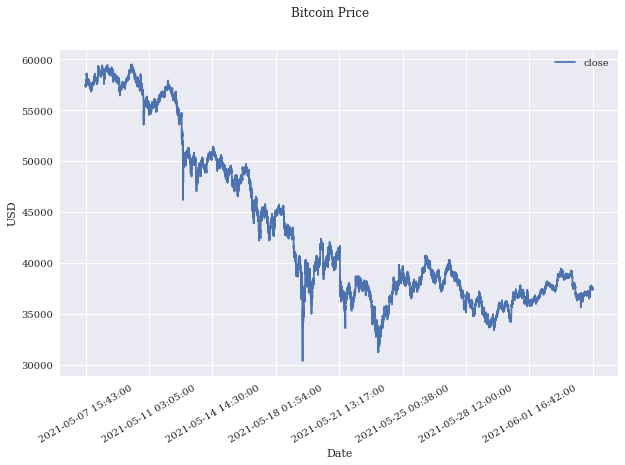

In [3]:
dates = pd.date_range('2015-01-02','2016-12-31',freq='B')
#symbols = ['goog','ibm','aapl']
df = get_crypto_price("BTC/USD", "1min", 5000)

for x in range(7):
    btc = get_crypto_price("BTC/USD", "1min", 5000, df.index[0])
    #btc = btc[['close']]
    df = pd.concat([btc, df])

df = df[['close']]
df['close'] = df['close'].astype('float')
df.fillna(method='pad')
df.plot(figsize=(10, 6), subplots=True, title="Bitcoin Price", xlabel="Date", ylabel="USD", rot=30);

In [4]:
df=df[['close']]

df=df.fillna(method='ffill')

scaler = MinMaxScaler(feature_range=(-1, 1))
df['close'] = scaler.fit_transform(df['close'].values.reshape(-1,1))
#df_ibm

## 3. Build Training/Testing Sets

In [5]:
# function to create train, test data given stock data and sequence length
def load_data(stock, look_back):
    data_raw = df.close # convert to numpy array
    data = []
    
    # create all possible sequences of length look_back
    for index in range(len(data_raw) - look_back): 
        data.append(data_raw[index: index + look_back])
    
    data = np.array(data);
    test_set_size = int(np.round(0.2*data.shape[0]));
    train_set_size = data.shape[0] - (test_set_size);
    
    x_train = data[:train_set_size,:-1]
    x_train = x_train[..., newaxis]
    y_train = data[:train_set_size,-1]
    y_train = y_train[..., newaxis]
    
    x_test = data[train_set_size:,:-1]
    x_test = x_test[..., newaxis]
    y_test = data[train_set_size:,-1]
    y_test = y_test[..., newaxis]
    
    return [x_train, y_train, x_test, y_test]

look_back = 60 # choose sequence length
x_train, y_train, x_test, y_test = load_data(df, look_back)
print('x_train.shape = ',x_train.shape)
print('y_train.shape = ',y_train.shape)
print('x_test.shape = ',x_test.shape)
print('y_test.shape = ',y_test.shape)

x_train.shape =  (31952, 59, 1)
y_train.shape =  (31952, 1)
x_test.shape =  (7988, 59, 1)
y_test.shape =  (7988, 1)


In [6]:
# make training and test sets in torch
x_train = torch.from_numpy(x_train).type(torch.Tensor)
x_test = torch.from_numpy(x_test).type(torch.Tensor)
y_train = torch.from_numpy(y_train).type(torch.Tensor)
y_test = torch.from_numpy(y_test).type(torch.Tensor)

## 4. Defining the Model

In [7]:
# Build model
#####################
input_dim = 1
hidden_dim = 32
num_layers = 2 
output_dim = 1


# Here we define our model as a class
class LSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(LSTM, self).__init__()
        # Hidden dimensions
        self.hidden_dim = hidden_dim

        # Number of hidden layers
        self.num_layers = num_layers

        # batch_first=True causes input/output tensors to be of shape
        # (batch_dim, seq_dim, feature_dim)
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)

        # Readout layer
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        # Initialize hidden state with zeros
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()

        # Initialize cell state
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()

        # We need to detach as we are doing truncated backpropagation through time (BPTT)
        # If we don't, we'll backprop all the way to the start even after going through another batch
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))

        # Index hidden state of last time step
        # out.size() --> 100, 32, 100
        # out[:, -1, :] --> 100, 100 --> just want last time step hidden states! 
        out = self.fc(out[:, -1, :]) 
        # out.size() --> 100, 10
        return out
    
model = LSTM(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim, num_layers=num_layers)

loss_fn = torch.nn.MSELoss()

optimiser = torch.optim.Adam(model.parameters(), lr=0.01)

## 5. Training Model

In [8]:
num_epochs = 100
hist = np.zeros(num_epochs)

# Number of steps to unroll
seq_dim =look_back-1  

for t in range(num_epochs):
    # Initialise hidden state
    # Don't do this if you want your LSTM to be stateful
    #model.hidden = model.init_hidden()
    
    # Forward pass
    y_train_pred = model(x_train)

    loss = loss_fn(y_train_pred, y_train)
    if t % 10 == 0 and t !=0:
        print("Epoch ", t, "MSE: ", loss.item())
    hist[t] = loss.item()

    # Zero out gradient, else they will accumulate between epochs
    optimiser.zero_grad()

    # Backward pass
    loss.backward()

    # Update parameters
    optimiser.step()

Epoch  10 MSE:  0.019398793578147888
Epoch  20 MSE:  0.010837080888450146
Epoch  30 MSE:  0.0032169525511562824
Epoch  40 MSE:  0.0020424965769052505
Epoch  50 MSE:  0.0011363023659214377
Epoch  60 MSE:  0.0005733045982196927
Epoch  70 MSE:  0.0002582829038146883
Epoch  80 MSE:  0.0001543331891298294
Epoch  90 MSE:  0.00014102962450124323


## 6. Visualizing Loss, Model Performance

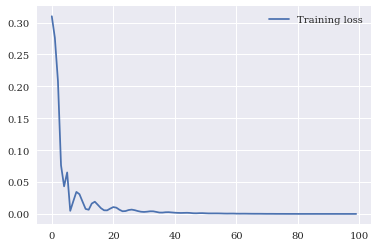

In [9]:
plt.plot(hist, label="Training loss")
plt.legend()
plt.show()

In [10]:
# make predictions
y_test_pred = model(x_test)

# invert predictions
y_train_pred = scaler.inverse_transform(y_train_pred.detach().numpy())
y_train = scaler.inverse_transform(y_train.detach().numpy())
y_test_pred = scaler.inverse_transform(y_test_pred.detach().numpy())
y_test = scaler.inverse_transform(y_test.detach().numpy())

In [ ]:
figure, axes = plt.subplots(figsize=(15, 6))
axes.xaxis_date()

axes.plot(df[len(df)-len(y_test):].index, y_test, color = 'red', label = 'Real Bitcoin Price')
axes.plot(df[len(df)-len(y_test):].index, y_test_pred, color = 'blue', label = 'Predicted Bitcoin Price')
#axes.xticks(np.arange(0,394,50))
plt.title('Bitcoin Price Prediction')
plt.xlabel('Time')
plt.ylabel('Bitcoin/USD')
plt.legend()
#plt.savefig('ibm_pred.png')
plt.show()

## 7. Directionality Test

What percent of the time does the model correctly predict bullish and bearish movements?

Calculated with help from https://www.geeksforgeeks.org/python-calculate-the-percentage-of-positive-elements-of-the-list/

In [ ]:
test_change = []
prediction_change = []

for x in range(1,len(y_test)):
    test_change.append(y_test[x]-y_test[x-1])
    prediction_change.append(y_test_pred[x]-y_test[x-1])

test_change = np.array(test_change)
prediction_change = np.array(prediction_change)

#If y(i) and pred(i) are both positive or both negative, product(i) will be positive. Negative otherwise.
product = np.multiply(test_change, prediction_change)

res = (len([ele for ele in product if ele > 0]) / len(product)) * 100

print("Correct direction predicted in " + str(res) + "% of cases.")